In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Replace 'your_file_path.csv' with your actual file path and name
file_path = 'user_profiles_for_ads.csv'  # Could be .csv, .xlsx, etc.

# Try reading the file (adjust parameters as needed)
try:
    # For CSV files
    df = pd.read_csv(file_path)    
    # Display basic info
    print("Data loaded successfully!")
    print(f"\nShape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
except Exception as e:
    print(f"Error loading file: {e}")

Data loaded successfully!

Shape: (1000, 16)

First 5 rows:
   User ID    Age  Gender  Location Language Education Level  \
0        1  25-34  Female  Suburban    Hindi       Technical   
1        2    65+    Male     Urban    Hindi             PhD   
2        3  45-54  Female  Suburban  Spanish       Technical   
3        4  35-44  Female     Rural  Spanish             PhD   
4        5  25-34  Female     Urban  English       Technical   

   Likes and Reactions  Followed Accounts  Device Usage  \
0                 5640                190   Mobile Only   
1                 9501                375        Tablet   
2                 4775                187   Mobile Only   
3                 9182                152  Desktop Only   
4                 6848                371   Mobile Only   

   Time Spent Online (hrs/weekday)  Time Spent Online (hrs/weekend)  \
0                              4.5                              1.7   
1                              0.5                        

In [3]:
# Handle missing data (adjust as needed)
def clean_data(df):
    # Drop columns with too many missing values (adjust threshold)
    threshold = len(df) * 0.7  # Keep columns with at least 70% data
    df = df.dropna(thresh=threshold, axis=1)
    
    # For remaining missing values in numerical columns
    num_cols = df.select_dtypes(include=np.number).columns
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

df_clean = clean_data(df.copy())
print("\nAfter cleaning - missing values:")
print(df_clean.isnull().sum())


After cleaning - missing values:
User ID                            0
Age                                0
Gender                             0
Location                           0
Language                           0
Education Level                    0
Likes and Reactions                0
Followed Accounts                  0
Device Usage                       0
Time Spent Online (hrs/weekday)    0
Time Spent Online (hrs/weekend)    0
Click-Through Rates (CTR)          0
Conversion Rates                   0
Ad Interaction Time (sec)          0
Income Level                       0
Top Interests                      0
dtype: int64


In [4]:
def engineer_features(df):
    # Example transformations (customize based on your columns)
    
    # If you have date/time columns
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_cols:
        try:
            df[col] = pd.to_datetime(df[col])
            df[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df[f'{col}_hour'] = df[col].dt.hour
        except:
            pass
    
    # Create engagement score if you have relevant columns
    engagement_components = []
    if 'clicks' in df.columns:
        engagement_components.append(df['clicks'])
    if 'time_spent' in df.columns:
        engagement_components.append(df['time_spent'] / df['time_spent'].max())
    if 'purchases' in df.columns:
        engagement_components.append(df['purchases'] * 2)  # Higher weight
    
    if engagement_components:
        df['engagement_score'] = sum(engagement_components) / len(engagement_components)
    
    return df

df_featured = engineer_features(df_clean.copy())
print("\nAdded features:")
print(df_featured.columns)


Added features:
Index(['User ID', 'Age', 'Gender', 'Location', 'Language', 'Education Level',
       'Likes and Reactions', 'Followed Accounts', 'Device Usage',
       'Time Spent Online (hrs/weekday)', 'Time Spent Online (hrs/weekend)',
       'Click-Through Rates (CTR)', 'Conversion Rates',
       'Ad Interaction Time (sec)', 'Income Level', 'Top Interests',
       'Time Spent Online (hrs/weekday)_dayofweek',
       'Time Spent Online (hrs/weekday)_hour',
       'Time Spent Online (hrs/weekend)_dayofweek',
       'Time Spent Online (hrs/weekend)_hour',
       'Ad Interaction Time (sec)_dayofweek',
       'Ad Interaction Time (sec)_hour'],
      dtype='object')


In [5]:
# Select features - modify based on your columns
potential_features = [
    'age',               # Demographic
    'income',            # Demographic
    'engagement_score',  # Behavioral
    'time_spent',        # Behavioral
    'purchases',         # Behavioral
    'clicks',            # Behavioral
    'device_type',       # Tech
    'location'           # Geographic
]

# Only keep features that exist in your dataframe
features_for_clustering = [f for f in potential_features if f in df_featured.columns]

# Add any other relevant numerical features
numerical_cols = df_featured.select_dtypes(include=np.number).columns.tolist()
additional_features = [f for f in numerical_cols if f not in features_for_clustering and f != 'user_id']
features_for_clustering.extend(additional_features)

print("\nFeatures selected for clustering:")
print(features_for_clustering)


Features selected for clustering:
['User ID', 'Likes and Reactions', 'Followed Accounts', 'Click-Through Rates (CTR)', 'Conversion Rates', 'Time Spent Online (hrs/weekday)_dayofweek', 'Time Spent Online (hrs/weekday)_hour', 'Time Spent Online (hrs/weekend)_dayofweek', 'Time Spent Online (hrs/weekend)_hour', 'Ad Interaction Time (sec)_dayofweek', 'Ad Interaction Time (sec)_hour']


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numerical and categorical features
numerical_features = df_featured[features_for_clustering].select_dtypes(include=np.number).columns.tolist()
categorical_features = df_featured[features_for_clustering].select_dtypes(include=['object', 'category']).columns.tolist()

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X = df_featured[features_for_clustering]
X_preprocessed = preprocessor.fit_transform(X)

print(f"\nPreprocessed data shape: {X_preprocessed.shape}")


Preprocessed data shape: (1000, 11)


Evaluating cluster counts: [2, 3, 4, 5, 6, 7, 8, 9, 10]


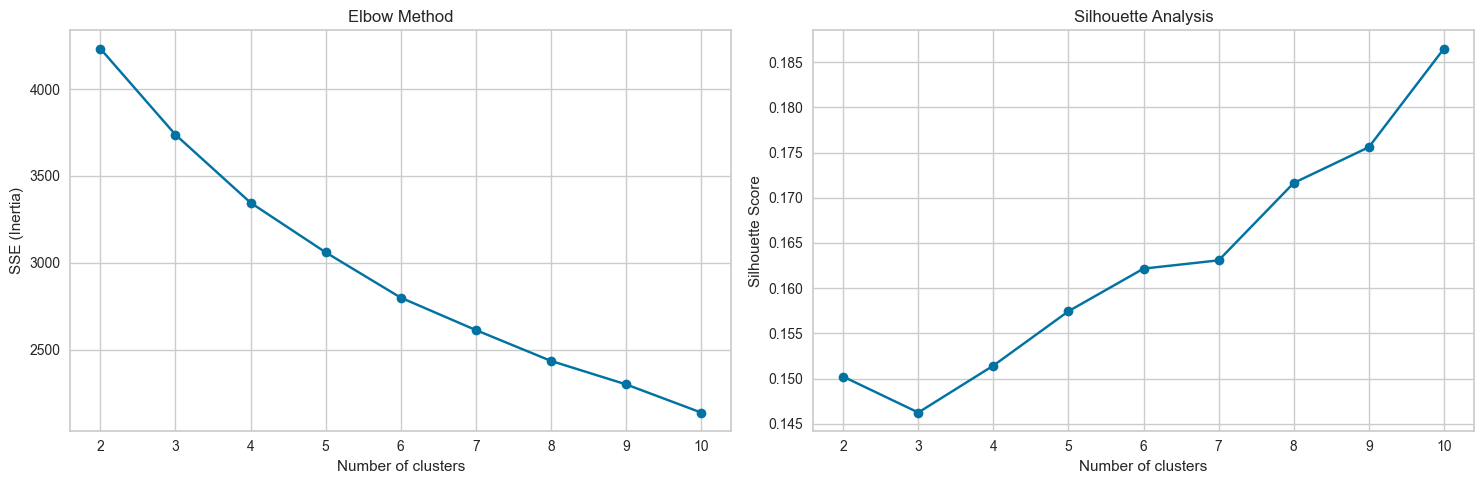


Recommended number of clusters: 10 (highest silhouette score)


In [10]:
# Determine range of clusters to try (2 to 10, or less if not enough samples)
max_possible_clusters = min(10, len(X_preprocessed) - 1)  # Need at least 2 samples per cluster
if max_possible_clusters < 2:
    raise ValueError("Not enough samples for clustering (need at least 2)")
    
k_range = range(2, max_possible_clusters + 1)
print(f"Evaluating cluster counts: {list(k_range)}")

# Calculate metrics
sse = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_preprocessed)
    sse.append(kmeans.inertia_)
    
    # Silhouette score requires at least 2 clusters and at least 2 samples per cluster
    if k > 1:
        try:
            score = silhouette_score(X_preprocessed, kmeans.labels_)
            silhouette_scores.append(score)
        except ValueError as e:
            print(f"Couldn't calculate silhouette score for k={k}: {str(e)}")
            silhouette_scores.append(np.nan)  # Mark as invalid

# Create plots
plt.figure(figsize=(15, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')

# Silhouette Score Plot - only plot valid scores
valid_k = k_range[:len(silhouette_scores)]  # May be shorter if some k values failed
valid_scores = [s for s in silhouette_scores if not np.isnan(s)]

if len(valid_k) != len(valid_scores):
    valid_k = list(k_range)[:len(valid_scores)]  # Ensure exact match

plt.subplot(1, 2, 2)
plt.plot(valid_k, valid_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# Determine optimal k (skip any nan scores)
if len(valid_scores) > 0:
    optimal_k = valid_k[np.argmax(valid_scores)]
    print(f"\nRecommended number of clusters: {optimal_k} (highest silhouette score)")
else:
    print("\nWarning: Could not calculate silhouette scores for any k > 1")
    # Fall back to elbow method
    diffs = np.diff(sse)
    relative_diffs = diffs[:-1] / diffs[1:]
    if len(relative_diffs) > 0:
        optimal_k = k_range[np.argmax(relative_diffs) + 1]
        print(f"Falling back to elbow method suggestion: {optimal_k} clusters")
    else:
        optimal_k = 2
        print("Defaulting to 2 clusters")

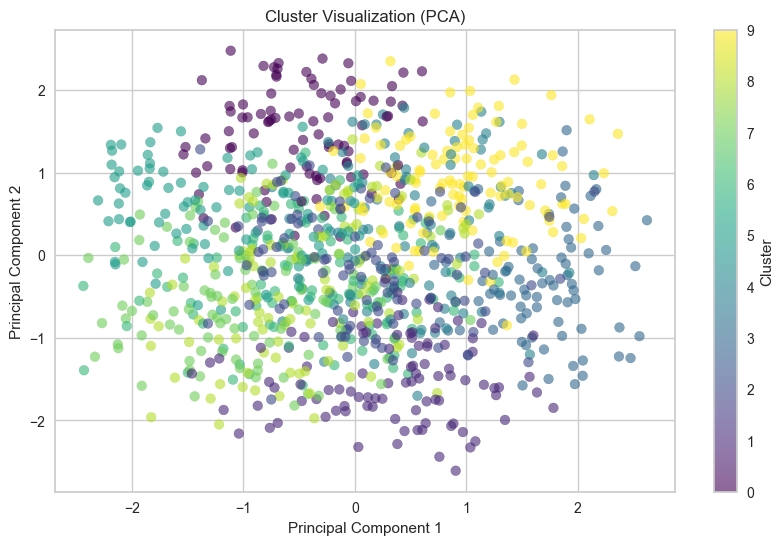

In [11]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_featured['cluster'] = kmeans.fit_predict(X_preprocessed)

# Visualize clusters (using PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed.toarray() if hasattr(X_preprocessed, 'toarray') else X_preprocessed)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_featured['cluster'], cmap='viridis', alpha=0.6)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [12]:
# Analyze cluster characteristics
cluster_profile = df_featured.groupby('cluster').agg({
    **{col: 'mean' for col in numerical_features},
    **{col: lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A' for col in categorical_features},
    'cluster': 'count'
}).rename(columns={'cluster': 'count'})

# Display profiles
pd.set_option('display.max_columns', None)
print("\nCluster Profiles:")
print(cluster_profile)

# Generate descriptive names for each cluster
def name_clusters(profile):
    cluster_names = {}
    for cluster in profile.index:
        traits = []
        
        # Check numerical features
        if 'age' in profile.columns:
            age = profile.loc[cluster, 'age']
            if age > profile['age'].quantile(0.75):
                traits.append('Older')
            elif age < profile['age'].quantile(0.25):
                traits.append('Younger')
                
        if 'engagement_score' in profile.columns:
            engagement = profile.loc[cluster, 'engagement_score']
            if engagement > profile['engagement_score'].quantile(0.75):
                traits.append('Highly Engaged')
            elif engagement < profile['engagement_score'].quantile(0.25):
                traits.append('Low Engagement')
                
        # Check categorical features
        if 'device_type' in profile.columns:
            device = profile.loc[cluster, 'device_type']
            traits.append(f"{device} Users")
            
        if not traits:
            traits.append('Typical')
            
        cluster_names[cluster] = ' '.join(traits)
    
    return cluster_names

cluster_names = name_clusters(cluster_profile)
print("\nSuggested Cluster Names:")
for cluster, name in cluster_names.items():
    print(f"Cluster {cluster}: {name}")

# Add names back to dataframe
df_featured['cluster_name'] = df_featured['cluster'].map(cluster_names)


Cluster Profiles:
            User ID  Likes and Reactions  Followed Accounts  \
cluster                                                       
0        221.225806          2862.580645         126.096774   
1        758.142857          6542.724490         367.275510   
2        818.285714          6790.173469         282.459184   
3        203.878049          8328.768293         367.365854   
4        300.823529          7019.460784         148.205882   
5        782.296703          2881.340659         219.747253   
6        372.583333          2303.481481         271.796296   
7        688.646465          2005.787879         194.040404   
8        563.947826          7359.843478         134.617391   
9        294.526316          4117.219298         410.122807   

         Click-Through Rates (CTR)  Conversion Rates  \
cluster                                                
0                         0.132828          0.072118   
1                         0.106184          0.023418   


In [13]:
# Generate recommendations based on clusters
def generate_recommendations(profile, cluster_names):
    recommendations = {}
    
    for cluster in profile.index:
        rec = {}
        name = cluster_names[cluster]
        count = profile.loc[cluster, 'count']
        percentage = (count / len(df_featured)) * 100
        
        # General characteristics
        rec['size'] = f"{count} users ({percentage:.1f}%)"
        
        # Targeting recommendations
        if 'Highly Engaged' in name:
            rec['targeting'] = "Focus on retention and upselling"
            rec['channel'] = "All channels with premium content"
        elif 'Low Engagement' in name:
            rec['targeting'] = "Focus on re-engagement campaigns"
            rec['channel'] = "Email and push notifications"
        else:
            rec['targeting'] = "General marketing campaigns"
            rec['channel'] = "Main advertising channels"
            
        # Content recommendations
        if 'Younger' in name:
            rec['content'] = "Trendy, visual content with social proof"
        elif 'Older' in name:
            rec['content'] = "Detailed, value-oriented content"
            
        # Device-specific recommendations
        if 'Mobile' in name:
            rec['format'] = "Mobile-optimized, short-form content"
        elif 'Desktop' in name:
            rec['format'] = "Longer-form content, detailed landing pages"
            
        recommendations[cluster] = rec
    
    return recommendations

cluster_recommendations = generate_recommendations(cluster_profile, cluster_names)

# Display recommendations
print("\nCluster Recommendations:")
for cluster, rec in cluster_recommendations.items():
    print(f"\nCluster {cluster} ({cluster_names[cluster]}):")
    for key, value in rec.items():
        print(f"  {key.replace('_', ' ').title()}: {value}")


Cluster Recommendations:

Cluster 0 (Typical):
  Size: 93 users (9.3%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 1 (Typical):
  Size: 98 users (9.8%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 2 (Typical):
  Size: 98 users (9.8%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 3 (Typical):
  Size: 82 users (8.2%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 4 (Typical):
  Size: 102 users (10.2%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 5 (Typical):
  Size: 91 users (9.1%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 6 (Typical):
  Size: 108 users (10.8%)
  Targeting: General marketing campaigns
  Channel: Main advertising channels

Cluster 7 (Typical):
  Size: 99 users (9.9%)
  Targeting: General marketing campaigns
  Channel: Main

In [15]:
# Save the clustered data
output_path = 'clustered_users.csv'
df_featured.to_csv(output_path, index=False)
print(f"\nClustered data saved to {output_path}")

# Save cluster profiles
profile_path = 'cluster_profiles.csv'
cluster_profile.to_csv(profile_path)
print(f"Cluster profiles saved")


Clustered data saved to clustered_users.csv
Cluster profiles saved


In [16]:
import joblib
from datetime import datetime
import os

# 1. Create a dictionary with all components to save
model_assets = {
    'model': kmeans,                      # Your trained KMeans model
    'preprocessor': preprocessor,         # The preprocessing pipeline
    'features': features_for_clustering,  # List of features used
    'cluster_profile': cluster_profile,   # Cluster characteristics
    'cluster_names': cluster_names,       # Descriptive names for clusters
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'version': '1.0'                     # Model version
}

# 2. Create a directory to save models if it doesn't exist
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# 3. Generate a filename with timestamp
model_filename = f"user_segmentation_model_{datetime.now().strftime('%Y%m%d_%H%M')}.pkl"
model_path = os.path.join(model_dir, model_filename)

# 4. Save all components
joblib.dump(model_assets, model_path)

# 5. Verify the save was successful
if os.path.exists(model_path):
    print(f"Model successfully saved to: {model_path}")
    print(f"Model contains: {list(model_assets.keys())}")
else:
    print("Error: Model failed to save!")

Model successfully saved to: saved_models\user_segmentation_model_20250625_1758.pkl
Model contains: ['model', 'preprocessor', 'features', 'cluster_profile', 'cluster_names', 'timestamp', 'version']
